In [1]:
# Dependencies
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

In [2]:
# Import images into numpy array, 'data'.
# Majority of images are shaped (110, 110, 3).
# Images of resolution divisible by 4 is required.
# Ref: https://github.com/loliverhennigh/Crystal-Gems
data = []
img_size = (110, 110, 3)
folder = 'Crystal-Gems/data'

for gem_folder in tqdm(os.listdir(folder)):
    gem_folder_name = os.path.join(folder, gem_folder)
    
    for gem_img in os.listdir(gem_folder_name):
        img = cv2.imread(os.path.join(gem_folder_name, gem_img))
        
        if img is not None and img.shape == (110,110,3):
            # Pad image to (112,112,3)
            padded_img = np.zeros(img_size, dtype=int)
            padded_img[:img.shape[0],:img.shape[1],:img.shape[2]] = img
            data.append(padded_img)

data = np.array(data)
print("data.shape:", data.shape)

100%|███████████████████████████████████████████████████████████████| 284/284 [00:01<00:00, 149.60it/s]


data.shape: (2937, 110, 110, 3)


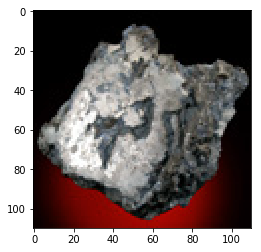

In [3]:
plt.imshow(data[0], cmap='gray')
plt.show()

In [4]:
# DCGAN
# Ref: https://github.com/eriklindernoren/Keras-GAN
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.models import load_model

import matplotlib.pyplot as plt

import sys

import numpy as np

class DCGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 112
        self.img_cols = 112
        self.channels = 3
        self.img_r = self.img_rows // 4
        self.img_c = self.img_cols // 4
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()
        
        model.add(Dense(128 * self.img_r * self.img_c, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((self.img_r, self.img_c, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        X_train = data

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        if len(X_train.shape) == 3:
            X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow((gen_imgs[cnt]*255).astype(np.uint8))
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/gem_%d.png" % epoch)
        plt.close()
        
    # Load pre-trained model
    def load_pretrained_model(self):
        self.discriminator = load_model('models/discriminator.h5')
        self.generator = load_model('models/generator.h5')
        
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
    
        self.discriminator.trainable = False

        valid = self.discriminator(img)
        
        optimizer = Adam(0.0002, 0.5)
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
    # Save model
    def save_model(self):
        self.discriminator.save('models/discriminator.h5')
        self.generator.save('models/generator.h5')

Using TensorFlow backend.


In [5]:
dcgan = DCGAN()
dcgan.load_pretrained_model()  # Total training: 15,150 epochs

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 56, 56, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 56, 56, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 29, 29, 64)        0         
_________________________________________________________________
batch_normalization_1

C:\Users\notes\Anaconda3\envs\trialgan\lib\site-packages\keras\engine\saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '
C:\Users\notes\Anaconda3\envs\trialgan\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


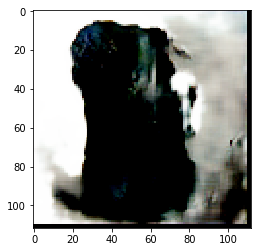

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


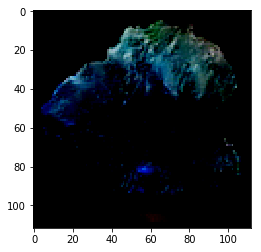

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


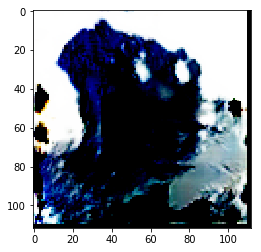

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


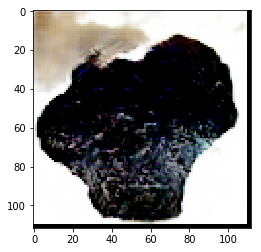

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


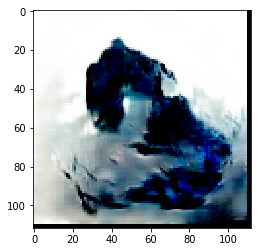

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


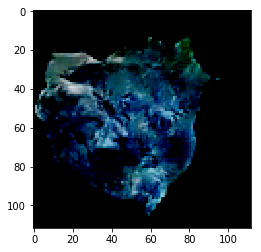

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


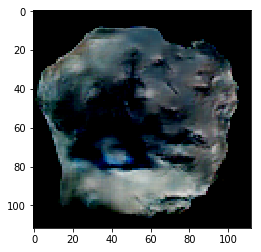

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


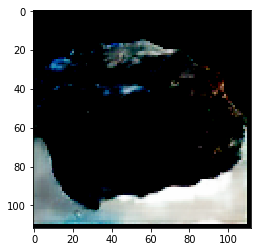

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


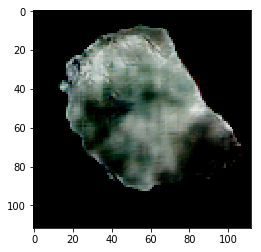

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


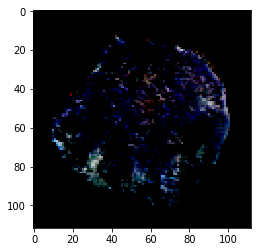

In [11]:
noise = np.random.normal(0, 1, (10, 100))
gen_imgs = dcgan.generator.predict(noise)
for i in range(10):
    plt.imshow(gen_imgs[i])
    plt.show()